## Import modules

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import to_categorical
from keras.datasets import cifar10

from PIL import Image

from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam


# Get Inception architecture from keras.applications
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


## Reading data

In [4]:
def load_cifar10(resize=False):
    train = np.load('/nfsroot/data/home/datasets/cse_7321c/cifar10/cifar_train.npz')
    x_train = train['data']
    y_train = train['labels']

    test = np.load('/nfsroot/data/home/datasets/cse_7321c/cifar10cifar_test.npz')
    x_test = test['data']
    y_test = test['labels']
    
    if resize:
        x_train=resize_all(x_train, resize)
        x_test=resize_all(x_test, resize)
    
    x_train = x_train.astype('float32')/255.
    x_test = x_test.astype('float32')/255.
    
    return(x_train, y_train, x_test, y_test)


def resize(p, size):
    return Image.fromarray(p).resize(size=(size,size))

def resize_all(arr, size):
    t = []
    for i in range(arr.shape[0]):
        t.append(np.array(resize(arr[i], size)))
        
#     t = np.array(t, dtype='float32')
#     t /= 255.

    return(np.array(t))

In [5]:
batch_size = 64
nb_classes = 10

img_rows, img_cols = 32, 32    # input image dimensions
img_channels = 3               # The CIFAR10 images are RGB.

In [6]:
(x_train, train_labels), (x_test, test_labels) = cifar10.load_data()
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

y_train = to_categorical(train_labels, nb_classes)
y_test = to_categorical(test_labels, nb_classes)

170500096/170498071 [==============================] - 423s 2us/step


## Plot a few train images

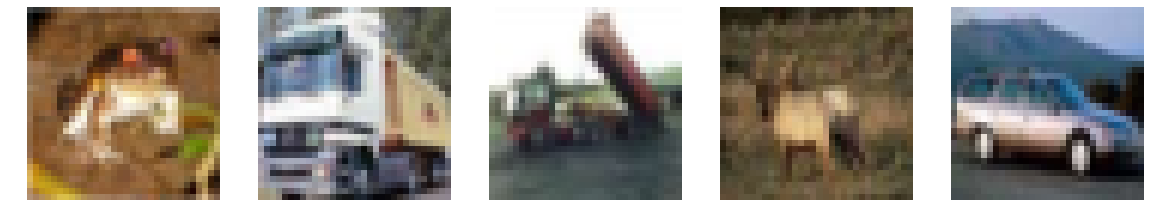

In [7]:
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')

## Custom Network

In [8]:
def custom_convnet(nb_classes, learn_rate, inp_shape):
    model = Sequential()
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), padding='same', # valid
                            input_shape=inp_shape, 
                            activation='relu'))
    model.add(Convolution2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    
    adam = Adam(lr=learn_rate)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    
    return(model)


With a lot of samples

In [9]:
model = custom_convnet(nb_classes=10, learn_rate=0.001, inp_shape=(img_rows,img_cols,img_channels))
model.fit(x_train[:50000], y_train[:50000],
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=5)

model.save('cifar10_savedmodel.h5')          # Saves the weights along with the graph
# model.save_weights('cifar10_savedmodel.h5')  # Saves the weights only

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 127s 3ms/step - loss: 1.4872 - acc: 0.4596 - val_loss: 1.1930 - val_acc: 0.5792
Epoch 2/5
50000/50000 [==============================] - 128s 3ms/step - loss: 1.0502 - acc: 0.6291 - val_loss: 0.8984 - val_acc: 0.6836
Epoch 3/5
50000/50000 [==============================] - 131s 3ms/step - loss: 0.8653 - acc: 0.6975 - val_loss: 0.8439 - val_acc: 0.7053
Epoch 4/5
50000/50000 [==============================] - 132s 3ms/step - loss: 0.7508 - acc: 0.7357 - val_loss: 0.7530 - val_acc: 0.7405
Epoch 5/5
50000/50000 [==============================] - 144s 3ms/step - loss: 0.6590 - acc: 0.7709 - val_loss: 0.7770 - val_acc: 0.7346


With limited samples

In [10]:
model = custom_convnet(nb_classes=10, learn_rate=0.001, inp_shape=(img_rows,img_cols,img_channels))
model.fit(x_train[:5000], y_train[:5000],
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=15)

Train on 5000 samples, validate on 10000 samples
Epoch 1/15
5000/5000 [==============================] - 22s 4ms/step - loss: 2.0718 - acc: 0.2232 - val_loss: 1.7554 - val_acc: 0.3569
Epoch 2/15
5000/5000 [==============================] - 23s 5ms/step - loss: 1.7067 - acc: 0.3740 - val_loss: 1.5479 - val_acc: 0.4283
Epoch 3/15
5000/5000 [==============================] - 23s 5ms/step - loss: 1.5621 - acc: 0.4358 - val_loss: 1.4509 - val_acc: 0.4594
Epoch 4/15
5000/5000 [==============================] - 21s 4ms/step - loss: 1.4435 - acc: 0.4692 - val_loss: 1.4568 - val_acc: 0.4746
Epoch 5/15
5000/5000 [==============================] - 19s 4ms/step - loss: 1.3371 - acc: 0.5098 - val_loss: 1.4555 - val_acc: 0.4682
Epoch 6/15
5000/5000 [==============================] - 20s 4ms/step - loss: 1.2483 - acc: 0.5436 - val_loss: 1.3171 - val_acc: 0.5334
Epoch 7/15
5000/5000 [==============================] - 21s 4ms/step - loss: 1.1556 - acc: 0.5872 - val_loss: 1.3653 - val_acc: 0.5208
Epoch 

## Pre-Trained Network

Resize all the images 

In [11]:
(x_train, train_labels), (x_test, test_labels) = cifar10.load_data()
size=224
x_train=resize_all(x_train, size)
x_test=resize_all(x_test, size)

x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

y_train = to_categorical(train_labels, nb_classes)
y_test = to_categorical(test_labels, nb_classes)

In [12]:
def inception_tl(nb_classes, freez_wts=True, learn_rate=0.001):
    trained_model = InceptionV3(include_top=False,weights='imagenet')
    x = trained_model.output
    x = GlobalAveragePooling2D()(x)
    pred_inception= Dense(nb_classes,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_inception)
    
    for layer in trained_model.layers:
        layer.trainable=(1-freez_wts)
    
    adam = Adam(lr=learn_rate)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    
    return(model)

In [18]:
model = inception_tl(nb_classes=nb_classes, freez_wts=True)
model.fit(x_train[:5000], y_train[:5000],
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=5)

87916544/87910968 [==============================] - 184s 2us/step
Train on 5000 samples, validate on 10000 samples
Epoch 1/5
5000/5000 [==============================] - 1295s 259ms/step - loss: 1.6024 - acc: 0.4844 - val_loss: 1.0274 - val_acc: 0.6591
Epoch 2/5
5000/5000 [==============================] - 1241s 248ms/step - loss: 1.0262 - acc: 0.6814 - val_loss: 0.9743 - val_acc: 0.6931
Epoch 3/5
5000/5000 [==============================] - 1228s 246ms/step - loss: 0.8883 - acc: 0.7130 - val_loss: 0.9393 - val_acc: 0.7126
Epoch 4/5
5000/5000 [==============================] - 1252s 250ms/step - loss: 0.8048 - acc: 0.7424 - val_loss: 0.9676 - val_acc: 0.7116
Epoch 5/5
5000/5000 [==============================] - 1218s 244ms/step - loss: 0.7605 - acc: 0.7570 - val_loss: 0.9718 - val_acc: 0.7213
